In [1]:
#!/usr/bin/env python

# Python Standard Library Modules
import os
import random
import pathlib
import sys
import warnings

# External Libraries
from gluonts.dataset import common
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model import deepar
from gluonts.mx.trainer import Trainer
from hyperopt import fmin, hp, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll import scope
import matplotlib
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")
mx.random.seed(0)
np.random.seed(0)

prediction_length = 30

### General Stocks

In [ ]:
gluon_list = []
def covert_yahoo_series_dir(path: str, prediction_length: int, gluon_list=None) -> list:
    """Clean and load all biotech histories in the Yahoo biotech folder

    Params:
        path: folder full of historical crypto coins timeseries data
        prediction_length: length on which to predict
    Returns:
        List of Gluon-compatible dicts from the coin data
    """
    if gluon_list is not None:
#         print("NOT NONE")
        gluon_list = gluon_list
    else:
        gluon_list = []
    for file in os.listdir(path):
#         print(file)
        stock_gluon_dict = dict()
        file_path = path + file
        stock = pd.read_csv(file_path)
        stock["Date"] = pd.to_datetime(stock["Date"])
        stock.set_index("Date", inplace=True)
        total_na_vals = stock.isna().sum()[0]
#         print(f"TOTAL NAs BEFORE ASFREQ B for {file} is {total_na_vals}")
        stock = stock.asfreq("B")
        total_na_vals = stock.isna().sum()[0]
#         print(f"TOTAL NAs for {file} is {total_na_vals}")
        if (total_na_vals / len(stock)) > 0.25:
            print(f"CONTINUED {file}")
            continue
        # Get values for ListDatasets
        stock_closes = stock["Close"]
        stock_closes.index = pd.DatetimeIndex(stock_closes.index)
#         stock_closes.dropna(inplace=True)
#         coin_closes.fillna(method='bfill', inplace=True)
#         coin_closes.dropna(inplace=True)
        stock_closes = stock_closes.asfreq("B")
#         stock_closes.dropna(inplace=True)
        start = stock_closes.index[0]
#         stock_closes = stock_closes.reset_index()

        stock_gluon_dict["test"] = {
            "start": start,
            "target": stock_closes,
            "name": file,
        }

        stock_gluon_dict["train"] = {
            "start": start,
            "target": stock_closes[:-prediction_length],
            "name": file,
        }

        gluon_list.append(stock_gluon_dict)

    return gluon_list


gluon_list = covert_yahoo_series_dir("../data/historical_yahoo_general_stocks/", prediction_length=30)

CONTINUED CMS-PB.csv


In [4]:
warnings.filterwarnings("always")

import mxnet as mx
mx.random.seed(0)
np.random.seed(0)


test_data = common.ListDataset(
    [
    ],
    freq="B",
)

train_data = common.ListDataset(
    [
    ],
    freq="B",
)

for stock_gluon_dict in gluon_list:
    test_data.list_data.append(stock_gluon_dict['test'])
    train_data.list_data.append(stock_gluon_dict['train'])

/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:158: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:166: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,
/Users/dan/opt/anaconda3/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:172: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,
100%|██████████| 50/50 [00:25<00:00,  1.94it/s, epoch=90/100, avg_epoch_loss=0.379]


100%|██████████| 50/50 [00:25<00:00,  1.92it/s, epoch=100/100, avg_epoch_loss=0.423]


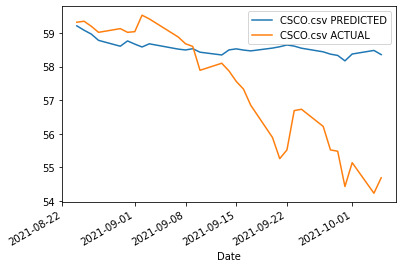

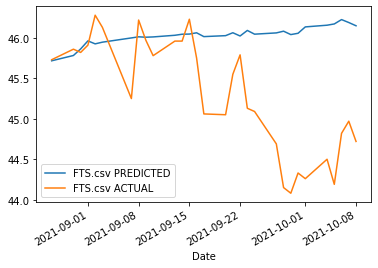

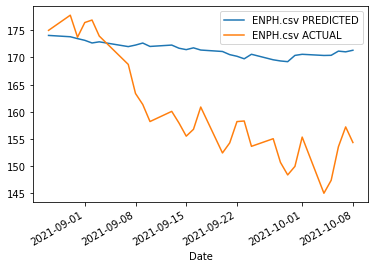

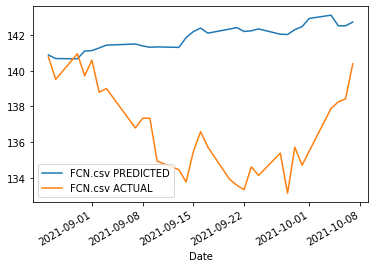

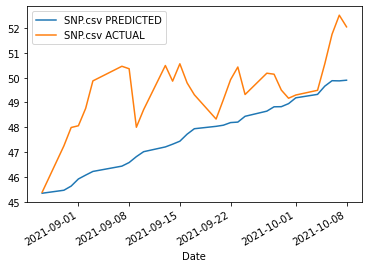

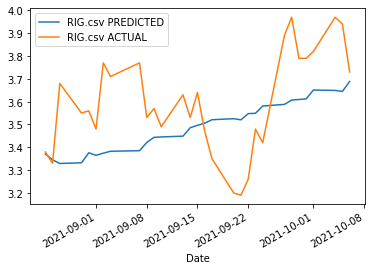

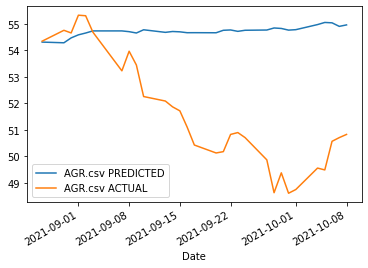

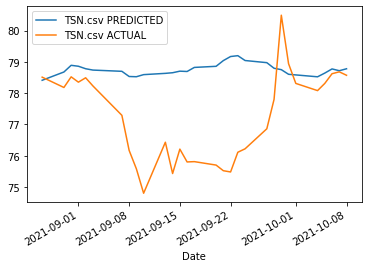

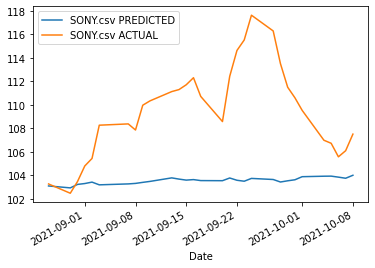

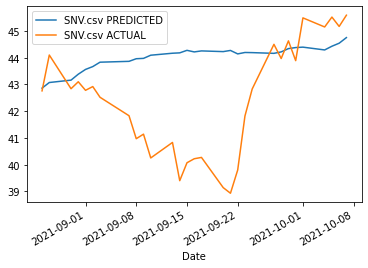

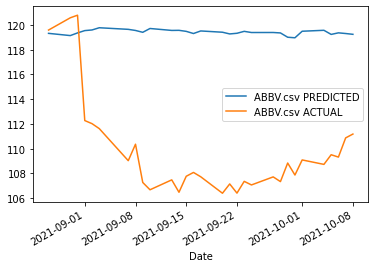

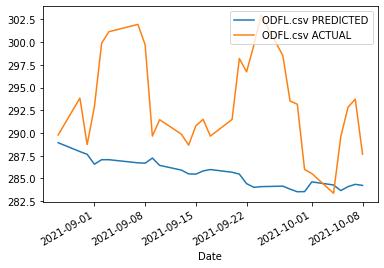

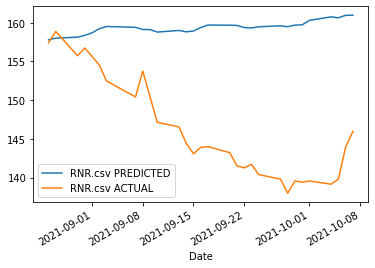

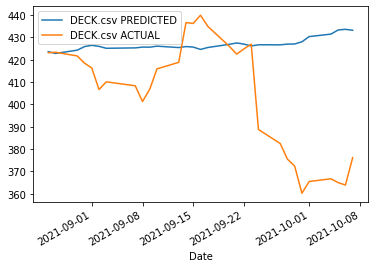

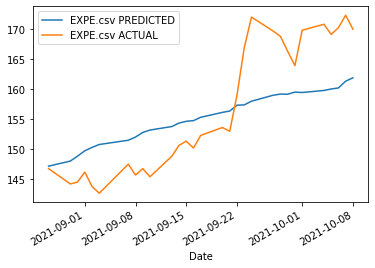

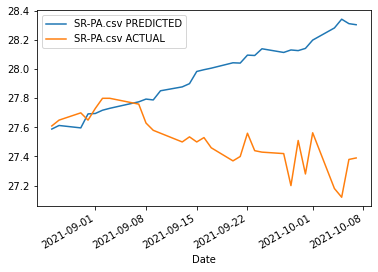

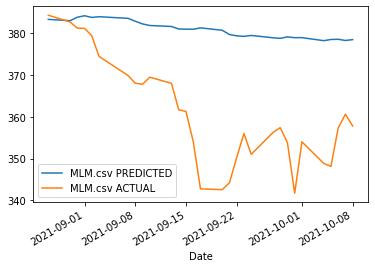

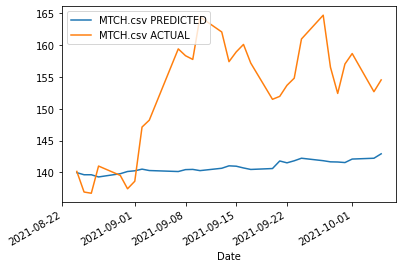

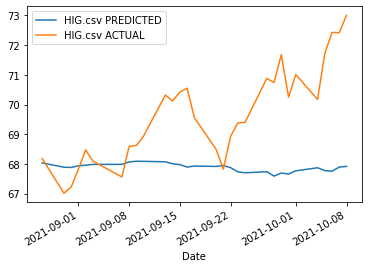

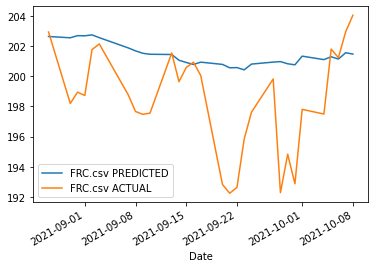

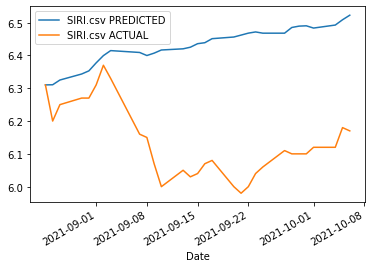

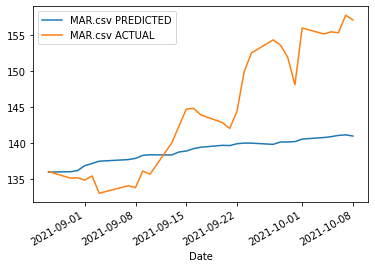

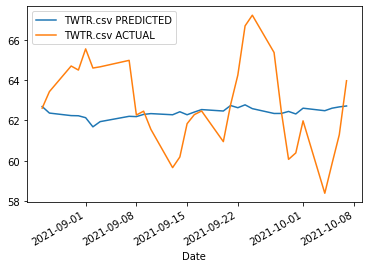

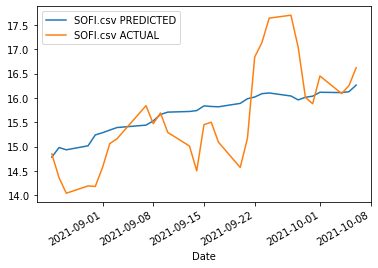

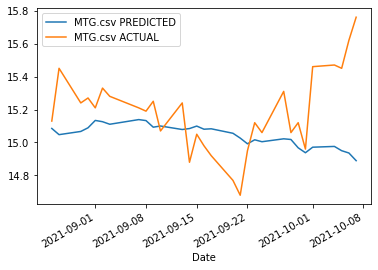

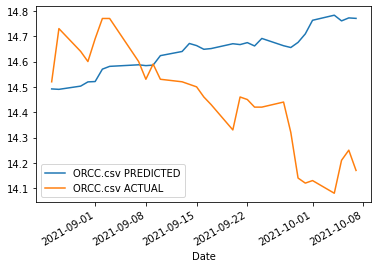

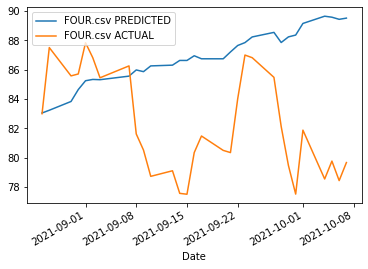

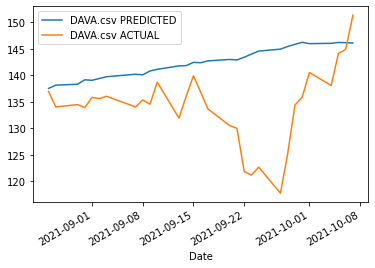

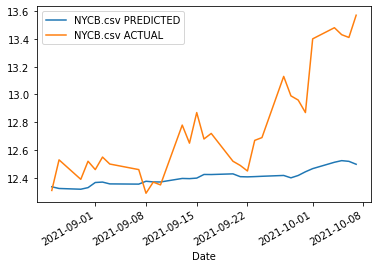

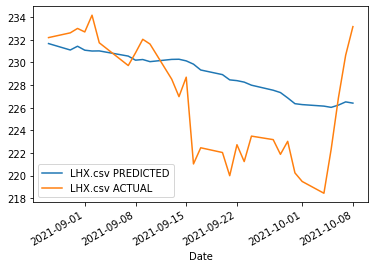

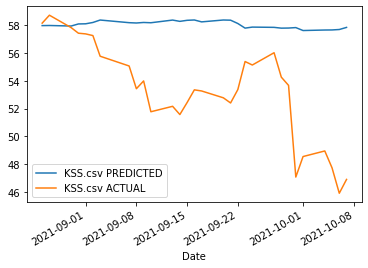

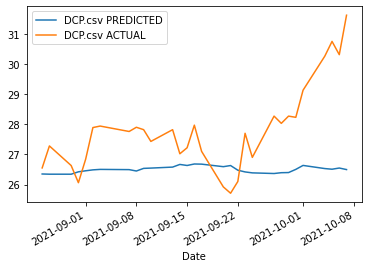

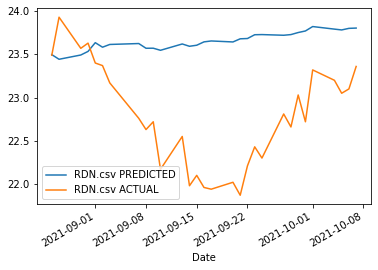

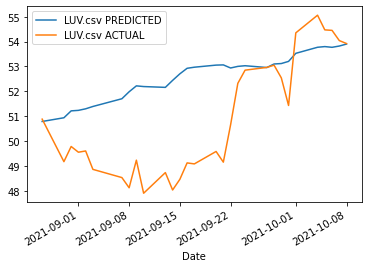

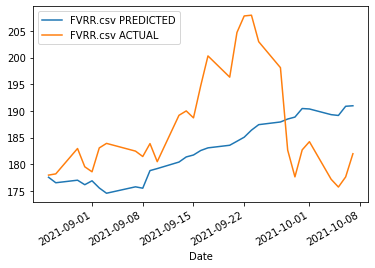

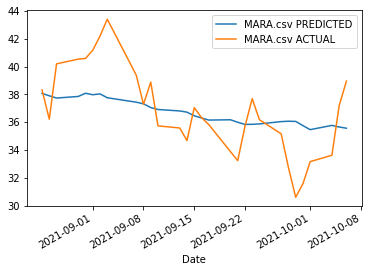

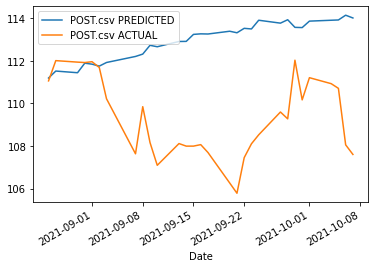

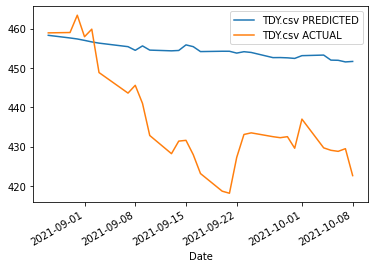

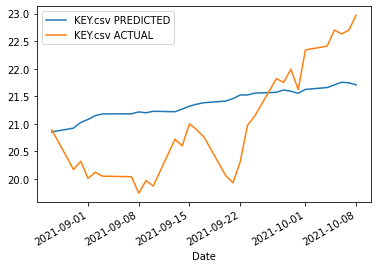

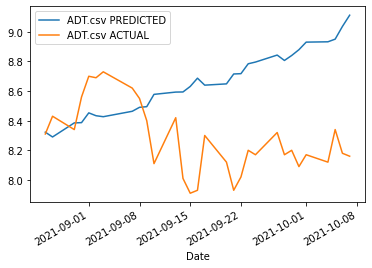

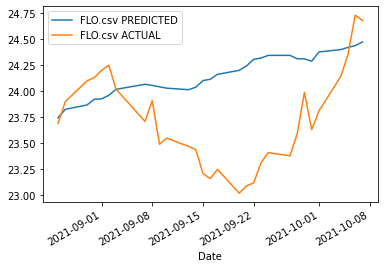

average global_loss is 0.30295166118033084


In [31]:
random.seed(0)
mx.random.seed(0)
np.random.seed(0)
global_loss = 0
trainer = Trainer(epochs=100)
estimator = deepar.DeepAREstimator(
        freq="B",
        num_cells=175,
        context_length=120,
        prediction_length=prediction_length, 
        trainer=trainer,
    )

predictor = estimator.train(
    training_data=train_data,
)


predictions = predictor.predict(train_data.list_data)


for index, value in enumerate(range(len(gluon_list))):
    prediction = next(predictions)
    name = test_data.list_data[index]['name']
    full_actual = test_data.list_data[index]['target']
    full_actual.dropna(inplace=True)
    actual = full_actual[-30:]
    preds = pd.Series(prediction.mean)
    preds.index = actual.index
#     mse = mean_squared_error(actual, preds)
    
#    PLOT ALL PREDICTIONS
    if index % 25 == 0:
        plt.figure()
        preds.plot(legend=True, label=f"{name} PREDICTED")
        actual.plot(legend=True, label=f"{name} ACTUAL")
        plt.show()

    
    scaler = MinMaxScaler()
    scaled_actual = np.array(actual)
    scaler.fit([scaled_actual])
    scaled_actual = scaler.fit_transform(np.array(scaled_actual[:, np.newaxis]))
    scaled_preds = scaler.transform([preds])
    scaled_preds = scaled_preds.reshape(-1, 1)
    mse = mean_squared_error(scaled_actual, scaled_preds)
#     print(f"mse: {mse}")
    global_loss += mse
    
print(f"average global_loss is {global_loss / len(gluon_list)}")

In [201]:
70 cells 5 layers 30 epochs 512 batch size 60 context length:    2.4904398118604307
70 cells 5 layers 30 epochs 512 batch size:                      0.9237185129645219
150 cells 3 layers 10 epochs:                                    5.2231017979000045
batch_size 512 10 epochs:                                        1.6157811417753714
batch_size 256 10 epochs:                                        1.2300746956301858
batch_size 128 10 epochs:                                        0.8353096293010092
batch_size 64 10 epochs:                                         1.3203255444205146

 


base all 60 epochs:                                              1.68
base all 50 epochs:                                              0.28
base all 40 epochs:                                              0.25
base all 30 epochs:                                              0.39
base all 20 epochs:                                              0.34
base all 10 epochs:                                              ~1.06


average global_loss is 1.2ish               # 18
average global_loss is 0.8193485594635367   # 36
average global_loss is 1.0578433766058088   # 54
average global_loss is 1.0184960608247695   # 69
average global_loss is 1.0639288802030842   # 86
average global_loss is 0.9494059324316426   # 204
average global_loss is 0.8880175967582968   # 241
average global_loss is 1.9637798520177      # 276 different exchange
average global_loss is 0.9105032333595303   # 240 attempted restore
average global_loss is 0.9554277347125465   # 258 w/ big tech movers
average global_loss is 0.335191223822778   # 258 w/ big tech movers 10 epochs
average global_loss is 0.6163794000905585   # 258 w/ big tech movers 50 epochs
average global_loss is 0.4051840267830506   # 258 wo/ big tech movers 10 epochs

SyntaxError: invalid syntax (<ipython-input-201-02862b3e764e>, line 1)

In [ ]:
random.seed(0)
mx.random.seed(0)
np.random.seed(0)

search_space = {
    'epochs': 20,
    'num_layers': scope.int(hp.quniform('num_layers', 1, 4, q=1)),
    'num_cells': scope.int(hp.quniform('num_cells', 30, 150, q=1)),
    'cell_type': hp.choice('cell_type', ['lstm', 'gru']),
    'learning_rate': hp.quniform('learning_rate', 5e-5, 1e-1, 0.00005),
    'context_length': scope.int(hp.quniform('context_length', 30, 200, q=1)),
    'dropout_rate': hp.quniform('dropout_rate', 0, 0.2, 0.005),
}

def global_objective(params):
    print(f"TRYING: {params}")
    try:
        deepar_params = {k: v for k,v in params.items() if k not in ('epochs', 'learning_rate')}
        epochs = params['epochs']
        learning_rate = params['learning_rate']
        cell_type = params['cell_type']
        trainer = Trainer(
                          epochs=epochs, 
                          learning_rate=learning_rate,
                          clip_gradient=2.5, # to avoid weird endless NaN bug
                          hybridize=False, # to avoid weird endless NaN bug
                          )
        estimator = deepar.DeepAREstimator(
            freq="1D", 
            prediction_length=prediction_length, 
            trainer=trainer,
            **deepar_params,
        )
        predictor = estimator.train(training_data=train_data)
        global_loss = 0
        predictions = predictor.predict(train_data.list_data)

        forecast_it, ts_it = make_evaluation_predictions(
            dataset=test_data,
            predictor=predictor,

        )

        forecasts = list(forecast_it)
        tss = list(ts_it)
        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

        agg_metrics, item_metrics = evaluator(
            iter(tss), 
            iter(forecasts), 
            num_series=len(test_data.list_data)
        )

        smape = agg_metrics['sMAPE']

        return {'loss': smape, 'status': STATUS_OK}
    
    except BaseException as e:
        print(f"ERROR: {e}")
        return {'status': STATUS_FAIL}

trials = Trials()
best = fmin(
    global_objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=60,
    trials=trials,
)

TRYING: {'cell_type': 'gru', 'context_length': 58, 'epochs': 20, 'learning_rate': 0.0287, 'num_cells': 148, 'num_layers': 3}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/50 [00:00<?, ?it/s]

 32%|###2      | 16/50 [00:10<00:21,  1.60it/s, epoch=1/20, avg_epoch_loss=8.76]

 32%|###2      | 16/50 [00:20<00:21,  1.60it/s, epoch=1/20, avg_epoch_loss=7.26]

 66%|######6   | 33/50 [00:20<00:10,  1.60it/s, epoch=1/20, avg_epoch_loss=7.15]

  0%|          | 0/50 [00:00<?, ?it/s]

 34%|###4      | 17/50 [00:10<00:19,  1.68it/s, epoch=2/20, avg_epoch_loss=4.85]

 70%|#######   | 35/50 [00:20<00:08,  1.70it/s, epoch=2/20, avg_epoch_loss=4.94]

  0%|          | 0/50 [00:00<?, ?it/s]

 34%|###4      | 17/50 [00:10<00:19,  1.70it/s, epoch=3/20, avg_epoch_loss=6.03]

 68%|######8   | 34/50 [00:20<00:09,  1.69it/s, epoch=3/20, avg_epoch_loss=5.53]

  0%|          | 0/50 [00:00<?, ?it/s]

 34%|###4      | 17/50 [00:10<00:19,  1.66it/s, epoch=4/20, avg_epoch_loss=6.04]

 68%|######8   | 34/50 [00:20<00:09,  1.66it/s, epoch=4/20, avg_epoch_loss=5.63]

  0%|          | 0/50 [00:00<?, ?it/s]

 34%|###4      | 17/50 [00:10<00:19,  1.69it/s, epoch=5/20, av

ERROR:                                                 
TRYING: {'cell_type': 'lstm', 'context_length': 33, 'epochs': 20, 'learning_rate': 0.0077, 'num_cells': 43, 'num_layers': 4}
  1%|          | 1/100 [09:03<14:56:16, 543.20s/trial, best loss=?]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|####4     | 22/50 [00:10<00:13,  2.14it/s, epoch=1/20, avg_epoch_loss=4.33]

 90%|######### | 45/50 [00:20<00:02,  2.19it/s, epoch=1/20, avg_epoch_loss=3.72]

  0%|          | 0/50 [00:00<?, ?it/s]

 16%|#6        | 8/50 [00:03<00:19,  2.15it/s, epoch=2/20, avg_epoch_loss=2.19]


ERROR:                                                             
TRYING: {'cell_type': 'gru', 'context_length': 84, 'epochs': 20, 'learning_rate': 0.0374, 'num_cells': 116, 'num_layers': 4}
  2%|▏         | 2/100 [09:30<6:31:53, 239.93s/trial, best loss=?]

  0%|          | 0/50 [00:00<?, ?it/s]

  6%|6         | 3/50 [00:04<01:02,  1.34s/it, epoch=1/20, avg_epoch_loss=26.2]


ERROR:                                                            
TRYING: {'cell_type': 'gru', 'context_length': 142, 'epochs': 20, 'learning_rate': 0.04295, 'num_cells': 59, 'num_layers': 3}
  3%|▎         | 3/100 [09:35<3:34:26, 132.64s/trial, best loss=?]

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|##        | 10/50 [00:10<00:41,  1.03s/it, epoch=1/20, avg_epoch_loss=7.2]

 42%|####2     | 21/50 [00:20<00:28,  1.02it/s, epoch=1/20, avg_epoch_loss=6.54]

 64%|######4   | 32/50 [00:31<00:17,  1.02it/s, epoch=1/20, avg_epoch_loss=5.99]

 86%|########6 | 43/50 [00:41<00:06,  1.03it/s, epoch=1/20, avg_epoch_loss=5.69]

  0%|          | 0/50 [00:00<?, ?it/s]

 22%|##2       | 11/50 [00:10<00:35,  1.08it/s, epoch=2/20, avg_epoch_loss=5.82]

 44%|####4     | 22/50 [00:20<00:25,  1.08it/s, epoch=2/20, avg_epoch_loss=6.08]

 66%|######6   | 33/50 [00:30<00:15,  1.08it/s, epoch=2/20, avg_epoch_loss=5.83]

 88%|########8 | 44/50 [00:40<00:05,  1.08it/s, epoch=2/20, avg_epoch_loss=5.6] 

